## 学习率调度

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

"""Z-score标准化输入使其平均数为0，标准差为1，
    加快梯度下降求最优解速度，可能可以提高精度"""
pixel_means = X_train.mean(axis=0, keepdims=True)#平均数
pixel_stds = X_train.std(axis=0, keepdims=True)#标准差
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

### 幂调度（Power Scheduling）:学习率开始时迅速下降，后来越来越慢

#### lr = lr0 / (1 + steps / s)**c

In [4]:
# Keras uses c=1 and s = 1 / decay
#s：步骤，t：迭代次数
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

### 指数调度（Exponential Scheduling）：每s步逐渐下降10倍

#### lr = lr0 * 0.1**(epoch / s)

In [5]:
def exponential_decay(lr0, s):
    #lr0为初始学习率
    
    def exponential_decay_fn(epoch):
        #采用当前轮次返回学习率
        return lr0 * 0.1**(epoch / s)
    
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

#### LearningRateScheduler（）在每个轮次开始时更新优化器的学习率

#### 若想更频繁的更新学习率（当每个轮次有很多步骤），可以自己编写回调函数

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam", 
              metrics=["accuracy"])

n_epochs = 25

"""将学习率传递给LearningRateScheduler回调函数，
    再将回调函数传递给fit（）"""
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
#history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
 #                   validation_data=(X_valid_scaled, y_valid),
  #                  callbacks=[lr_scheduler])

### 分段恒定调度（Piecewise Constant Scheduling）

In [7]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [8]:
"""更通用"""
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    #argmax（）返回最大值的索引
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [9]:
"""将学习率传递给LearningRateScheduler回调函数，
    再将回调函数传递给fit（）"""
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
#history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
 #                   validation_data=(X_valid_scaled, y_valid),
  #                  callbacks=[lr_scheduler])

### 性能调度（Performance Scheduling）

In [10]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
#使用ReduceLROnPlateau回调函数，当5个轮次最好验证损失没有改善则将学习率*0.5

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
#history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
          #          validation_data=(X_valid_scaled, y_valid),
           #         callbacks=[lr_scheduler])

### tf.keras schedulers：每个步骤更新学习率

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
#python//表示取整除 ，返回商的整数部分（向下取整）

learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
#使用指数衰减的学习率
#初始值是0.01，梯度为s，衰减率（底数）为0.1，每s步学习率*0.1

optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
#history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
           #         validation_data=(X_valid_scaled, y_valid))

In [12]:
#分段恒定调度的学习率，每个步骤更新
n_steps_per_epoch = 10#每个轮次的步骤数

learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1周期方法（1Cycle scheduling）

In [13]:
K = keras.backend
#后端
class ExponentialLearningRate(keras.callbacks.Callback):
    """根据系数factor指数调度学习率，
    使学习率与factor相乘，进行线性变换"""
    
    def __init__(self, factor):
        """每个与类相关联的方法调用都自动传递实参self
           以self为前缀的变量可以供类中的所有办法使用"""
        
        self.factor = factor #系数
        #获取存储在形参factor中的值并存储到变量factor中
        
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        """在每个批次处理的最后，保存模型的lr和loss，
           对模型学习率进行线性增长（×factor）"""
        
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        #将模型优化器的学习率参数添加进（存储在）rates数组
        
        self.losses.append(logs["loss"])
        #将日志中计算出的loss保存至losses数组
        
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)
        #tf.keras.backend.set_value(x,value)，从Numpy数组将值载入tensor中
        #x：要设置为新值的Tensor
        #value：Numpy数组（具有相同形状），将载入x
        #将模型的学习率设置为：与系数factor相乘后的学习率

In [14]:
import math

def find_learning_rate(model, X, y, epochs=1, batch_size=32,
                       min_rate=10**-5, max_rate=10):
    """找到最优学习率，设置为最大学习率，
       初始最小学习率设置为10的-5次方，最大学习率设置为10，
       在此范围内寻找最优学习率"""
    
    init_weights = model.get_weights()#获得模型原始参数
    
    iterations = math.ceil(len(X) / batch_size) * epochs
    #学习率总迭代次数
    #lr在处理每个batch批次的最后和每个epoch的最后更新
    #math.ceil(x) 方法将 x 向上舍入到最接近的整数
    
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    #系数"""按需设置"""
    #numpy.exp()：返回e的幂次方，e是一个常数为2.71828
    
    init_lr = K.get_value(model.optimizer.learning_rate)
    #得到模型原始学习率init_lr
    
    K.set_value(model.optimizer.learning_rate, min_rate)
    #将模型学习率设置为最小学习率min_rate，
    
    exp_lr = ExponentialLearningRate(factor)
    #在每个轮次训练的最后lr都与factor相乘在训练中途线性增长
    #每个轮次都保存lr到rates数组，保存loss到losses数组
    
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    #训练模型
    
    K.set_value(model.optimizer.learning_rate, init_lr)
    #将模型学习率设置为初始学习率init_lr
    
    model.set_weights(init_weights)
    #将模型权重设置为初始权重
    
    return exp_lr.rates, exp_lr.losses
    #返回记录了每个批次变化的学习率和loss的rates[]和losses[]

In [15]:
%matplotlib inline
#使得图片可见
import matplotlib.pylab as plt#导入绘图库

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

430/430 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.3669


[1e-05, 9.683906, 1.650153398513794, 3.204094512122018]

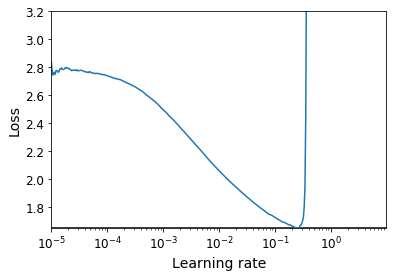

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train,
                                   epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
"""找到图中损失值降低的最快的点对应的学习率，确定最优学习率"""
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [17]:
class OneCycleScheduler(keras.callbacks.Callback):
    """训练开始到中途从 lr0（0.005）到lr1（0.05），
    训练的后半部分降回lr0（0.005），
    最后的几个轮次再往下降到1.0663265306122723e-05"""

    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        
        self.iterations = iterations
        #学习率迭代次数#print(iterations) #设置为8800
        
        self.max_rate = max_rate 
        #学习率最大值#print(max_rate)  #设置为0.05
        
        self.start_rate = start_rate or max_rate / 10 #初始学习率
        #最大学习率大约比初始学习率大10倍 #print(self.start_rate)#0.005
        
        self.last_iterations = last_iterations or iterations // 10 + 1
        #最后几个轮次学习率的迭代次数
        #lr0-lr1和lr1-lr0各占据学习率迭代的约一半，最后lr0降低几个数量级相当于1/11
        #//为整除 #print(self.last_iterations) #881
        
        self.half_iteration = (iterations - self.last_iterations) // 2
        #训练到中途学习率的迭代次数
        #print(self.half_iteration) #3959 #print(2 * self.half_iteration)#7918
        
        self.last_rate = last_rate or self.start_rate / 1000
        #最后几个轮次的 学习率
        #print(self.last_rate) #5e-06
        
        self.iteration = 0
        #将当前学习率迭代次数设置为0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        #插值
        """学习率迭代次数从iter1到iter2的过程中，学习率从rate1线性变化到rate2"""
        return ((rate2 - rate1) * (self.iteration - iter1)/ (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        #在每个批次开始时
        
        if self.iteration < self.half_iteration:
            #第一阶段，lr0-lr1
            rate = self._interpolate(0, self.half_iteration, 
                                     self.start_rate, self.max_rate)
            
        elif self.iteration < 2 * self.half_iteration:
            #第二阶段，lr1-lr2
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
            
        else:
            #第三阶段，最后几个批次学习率降低几个数量级
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
              
        self.iteration += 1
        #当前学习率迭代次数＋1
        
        K.set_value(self.model.optimizer.lr, rate)
        #将变化的学习率应用于模型优化器的学习率

In [18]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, 
                             max_rate=0.05)
#传入学习率迭代次数和最大学习率

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6544 - accuracy: 0.7763 - val_loss: 0.4773 - val_accuracy: 0.8370
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4528 - accuracy: 0.8424 - val_loss: 0.4282 - val_accuracy: 0.8530
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4096 - accuracy: 0.8566 - val_loss: 0.4060 - val_accuracy: 0.8578
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3822 - accuracy: 0.8655 - val_loss: 0.3909 - val_accuracy: 0.8646
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8726 - val_loss: 0.3856 - val_accuracy: 0.8660
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3433 - accuracy: 0.8786 - val_loss: 0.3682 - val_accuracy: 0.8762
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3272 - accuracy: 0.8830 - val_loss: 0.3599 - val_accuracy: 0.8702
Epoch 